# Run one sample correlation test

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
adata.shape

(69958, 36588)

### Setup memento

In [10]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [11]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [12]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Define TFs

In [11]:
filtered_tfs = """MAFG
SPI1
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
ARID5A
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
MSC
ATF5
MAFB
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
TFEC
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6""".split()

### One sample test for all TFs

In [14]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()
adata_ctrl.obs['group'] = 'A'

In [15]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [16]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [ ]:
for tf in filtered_tfs:
    
    if tf not in adata_ctrl.var.index.tolist():
        continue
    
    print('Control correlations for:', tf)
    
    memento.compute_2d_moments(adata_ctrl, list(itertools.product([tf], adata_ctrl.var.index.tolist())))
    
    memento.ht_2d_moments( 
        adata_ctrl, 
        formula_like='1',
        cov_column='Inter', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14)
    
    adata_ctrl.write(data_path + 'control_corr/{}.h5ad'.format(tf))

### Get number of significantly correlated genes for each TF

In [17]:
tf_list = list(set(filtered_tfs) & set(adata_ctrl.var.index))

In [18]:
output_dfs = {}
for tf in tf_list:
    
    adata_tf = sc.read(data_path + 'control_corr/{}.h5ad'.format(tf))
    tf_result = memento.get_2d_ht_result(adata_tf)
    tf_result['corr_fdr'] = memento.util._fdrcorrect(tf_result['corr_pval'])
#     tf_result = tf_result.query('~gene_2.str.contains("RPS") & ~gene_2.str.contains("RPL")', engine='python')
    output_dfs[tf] = tf_result

### Combine all edges

### Volcano plots for STAT1, IRF7

In [19]:
def tf_volcano(tf):
    tf_result = output_dfs[tf]
    tf_result['logp'] = -np.log10(tf_result['corr_pval'])
    plt.scatter(tf_result['corr_coef'],tf_result['logp'], s=0.1, color='grey')
    plt.scatter(
        tf_result.query('corr_fdr < 0.1')['corr_coef'],
        tf_result.query('corr_fdr < 0.1')['logp'], s=1.2)
    plt.title(tf); plt.ylabel('log P-value'); plt.xlabel('correlation')
    
    return tf_result

Text(0, 0.5, '')

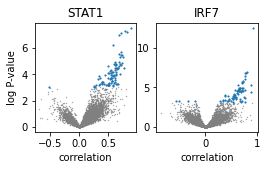

In [20]:
plt.figure(figsize=(4,2))
plt.subplot(1, 2, 1);
stat1_df = tf_volcano('STAT1')
plt.subplot(1, 2, 2)
irf7_df = tf_volcano('IRF7')
plt.ylabel(None)
# plt.savefig(fig_path + 'tf_volcano.png', bbox_to_inches='tight', dpi=300)

In [21]:
irf7_df.sort_values('logp', ascending=False).head(20)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,logp
9583,IRF7,MX1,0.917227,0.060723,2.976680e-13,3.020735e-09,12.526268
6581,IRF7,EPSTI1,0.798548,0.083384,1.135444e-07,3.909930e-04,6.944834
2538,IRF7,HERC6,0.767718,0.104611,1.314186e-07,3.909930e-04,6.881343
5206,IRF7,IFIT1,0.781096,0.085885,1.541163e-07,3.909930e-04,6.812152
9582,IRF7,MX2,0.754638,0.087823,3.618774e-07,7.344663e-04,6.441439
4,IRF7,ISG15,0.751050,0.073313,7.585380e-07,1.282941e-03,6.120023
462,IRF7,IFI44L,0.712595,0.086325,1.781597e-06,2.283974e-03,5.749191
6406,IRF7,OAS1,0.697910,0.107587,1.917242e-06,2.283974e-03,5.717323
5388,IRF7,IFITM3,0.724710,0.074521,2.025598e-06,2.283974e-03,5.693447
203,IRF7,IFI6,0.697548,0.064869,2.521014e-06,2.558325e-03,5.598425


In [224]:
tf_result = output_dfs['IRF7']
tf_result['logp'] = -np.log(tf_result['corr_pval'])

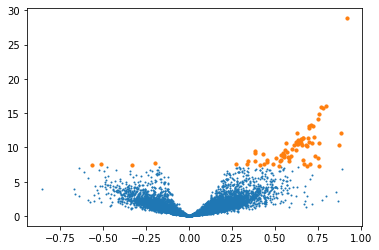

In [226]:
plt.scatter(tf_result['corr_coef'],tf_result['logp'], s=1)
plt.scatter(
    tf_result.query('corr_fdr < 0.1')['corr_coef'],
    tf_result.query('corr_fdr < 0.1')['logp'], s=10)

### TF-wide enrichment analysis

In [174]:
import gseapy as gp

In [184]:
enrichment_dfs = {}
for tf, df in output_dfs.items():
    
    sig_genes = df.query('corr_fdr < 0.05 & corr_coef > 0').gene_2.tolist()
    
    print(tf, len(sig_genes))
    
    if len(sig_genes) < 10:
        
        continue
    
    enr = gp.enrichr(
        gene_list=sig_genes,
        gene_sets=['Reactome_2016'],
        organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
        description='test_name',
        outdir='./gsea/',
        # no_plot=True,
        cutoff=0.5 # test dataset, use lower value from range(0,1)
    )
    
    enrichment_dfs[tf] = enr.results
    enrichment_dfs[tf]['term'] = enrichment_dfs[tf]['Term'].apply(lambda x : ' '.join(x.split(' ')[:-3]))
    enrichment_dfs[tf] = enrichment_dfs[tf][['term', 'Adjusted P-value']]

ETV6 0
CEBPD 212
ZNF655 0
ATF5 0
RBPJ 0
CREM 89
JUN 51
NFE2L2 1537
AHR 18
GTF2B 437
NR3C1 0
JUNB 8
ATF3 0
TGIF1 0
NFKB1 0
ATF4 0
FOS 300
HBP1 0
MAX 0
CEBPB 426
IRF1 0
NR1H2 0
BBX 29
BACH1 0
MAFG 0
ZNF267 0
IRF2 1
STAT3 1
RELB 0
XBP1 581
KLF6 12
YY1 624
YBX1 1755
IRF7 52
REL 0
ELF1 10
DDIT3 0
IRF9 166
HIF1A 40
STAT1 60
HMGA1 45


In [204]:
enrichment_dfs['YBX1'].head(15)

,term,Adjusted P-value
0,Respiratory electron transport,1.153592e-39
1,"Respiratory electron transport, ATP synthesis ...",1.927268e-34
2,The citric acid (TCA) cycle and respiratory el...,4.176789e-34
3,Gene Expression,4.341471e-30
4,HIV Infection,3.237568e-27
5,APC/C:Cdc20 mediated degradation of mitotic pr...,2.807358e-23
6,Activation of APC/C and APC/C:Cdc20 mediated d...,5.010658e-23
7,Complex I biogenesis,5.481349e-23
8,Processing of Capped Intron-Containing Pre-mRNA,1.465695e-22
9,AUF1 (hnRNP D0) binds and destabilizes mRNA,3.104418e-22


### NLRC5 analysis

In [101]:
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['gamma']) & \
    adata.obs.time.isin(['3']), :].copy()

memento.create_groups(adata_stim, label_columns=['donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
stim_gene_list = adata_stim.var.index.tolist()
memento.compute_2d_moments(adata_stim, list(itertools.product(['NLRC5'], stim_gene_list)))

df = memento.get_2d_moments(adata_stim, groupby='ALL')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [102]:
df.query('gene_2.str.contains("HLA")', engine='python')

,gene_1,gene_2,ALL_sg
445,NLRC5,HHLA3,-0.014753
2038,NLRC5,HHLA2,0.251472
3306,NLRC5,HLA-F,0.366060
3307,NLRC5,HLA-A,0.568791
3316,NLRC5,HLA-E,0.468605
3332,NLRC5,HLA-C,0.286416
3333,NLRC5,HLA-B,0.293612
3370,NLRC5,HLA-DRA,0.040235
3371,NLRC5,HLA-DRB5,-0.018770
3372,NLRC5,HLA-DRB1,0.096314


In [98]:
df

,gene_1,gene_2,ALL_sg
0,NLRC5,LINC01409,0.075796
1,NLRC5,LINC01128,-0.205743
2,NLRC5,FAM41C,-0.038849
3,NLRC5,PLEKHN1,0.024070
4,NLRC5,HES4,0.224785
...,...,...,...
10486,NLRC5,VBP1,-0.151226
10487,NLRC5,TMLHE,0.107951
10488,NLRC5,VAMP7,0.162647
10489,NLRC5,RPS4Y1,0.305270


### Filter TFs based on 1d correlation significance

In [26]:
tf_df = pd.read_csv('../DatabaseExtract_v_1.01.csv', index_col=0)
# tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

In [27]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['gamma']) & \
    adata.obs.time.isin(['6']), :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [28]:
memento.create_groups(adata_ctrl, label_columns=['donor'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

memento.create_groups(adata_stim, label_columns=['donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

In [29]:
filtered_tfs_ctrl = list(set(tfs) & set(adata_ctrl.var.index))
filtered_tfs_stim = list(set(tfs) & set(adata_stim.var.index))

In [ ]:
filtered_tf_corrs = {}
ctrl_gene_list = adata_ctrl.var.index.tolist()
for tf in filtered_tfs_ctrl:
    
    memento.compute_2d_moments(adata_ctrl, list(itertools.product([tf], ctrl_gene_list)))
    filtered_tf_corrs[tf] = memento.get_2d_moments(adata_ctrl, groupby='ALL')['ALL_sg'].values

In [ ]:
tf_corr_df_ctrl = pd.DataFrame()
for tf in filtered_tfs_ctrl:
    tf_corr_df_ctrl[tf] = filtered_tf_corrs[tf]
tf_corr_df_ctrl.index = ctrl_gene_list
tf_corr_df_ctrl.to_csv('ctrl_tf_corrs.csv')

In [ ]:
filtered_tf_corrs = {}
stim_gene_list = adata_stim.var.index.tolist()
for tf in filtered_tfs_stim:
    
    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], stim_gene_list)))
    filtered_tf_corrs[tf] = memento.get_2d_moments(adata_stim, groupby='ALL')['ALL_sg'].values

In [ ]:
tf_corr_df_stim = pd.DataFrame()
for tf in filtered_tfs_stim:
    tf_corr_df_stim[tf] = filtered_tf_corrs[tf]
tf_corr_df_stim.index = stim_gene_list
tf_corr_df_stim.to_csv('stim_tf_corrs.csv')

In [ ]:
tf_corr_df_stim['gene'] = tf_corr_df_stim.index.tolist()

In [ ]:
tf_corr_df_stim = pd.read_csv('stim_tf_corrs.csv')
tf_corr_df_ctrl = pd.read_csv('ctrl_tf_corrs.csv')

In [33]:
tf_corr_df_stim['gene'] = adata_stim.var.index.tolist()
tf_corr_df_ctrl['gene'] = adata_ctrl.var.index.tolist()

In [34]:
tf_corr_df_stim.head(5)

,ACTR3B,TAB1,MED13L,E2F7,NFAT5,YEATS4,ZNF844,WFS1,COPS3,CIITA,...,ZNF487,PIM1,LCOR,PRDM4,UBC,ATF2,ZNF75D,ZNF552,CREB3L4,gene
0,0.320735,0.086614,0.446918,-0.020789,0.142234,0.105901,0.396371,0.346563,0.188275,0.144554,...,0.108347,-0.143583,0.191050,0.619101,0.051451,-0.050463,0.639755,-0.424733,0.168623,LINC01409
1,0.103067,-0.171127,0.580792,-0.164543,0.028080,-0.153544,0.498916,0.353243,-0.032517,-0.018361,...,0.040724,-0.278476,0.332420,0.937208,-0.018009,-0.030568,0.313004,0.185402,0.137950,NOC2L
2,0.107324,0.309344,0.192095,0.016029,0.102088,-0.178435,0.213778,0.087417,-0.098012,-0.078697,...,0.050214,0.119073,0.196444,-0.191628,0.118298,0.202612,0.391785,0.108344,0.223987,PLEKHN1
3,-0.113119,0.125800,0.276850,-0.092226,0.477099,0.013646,0.080293,0.024794,0.085871,0.138065,...,-0.094223,0.189497,0.339797,0.071937,0.610392,0.238477,0.017943,0.192192,-0.068688,HES4
4,-0.005547,0.347604,-0.062492,-0.069297,0.078058,0.125441,0.217623,0.020207,0.253964,0.067645,...,0.260806,-0.015116,0.074186,0.172490,0.506140,0.194455,-0.016137,0.045595,-0.001087,ISG15


In [35]:
tf_corr_df_stim = pd.melt(tf_corr_df_stim, 'gene').rename(columns={'variable':'tf', 'value':'corr'})
tf_corr_df_ctrl = pd.melt(tf_corr_df_ctrl, 'gene').rename(columns={'variable':'tf', 'value':'corr'})

In [55]:
a = tf_corr_df_ctrl.groupby('tf')['corr'].mean().sort_values(ascending=False)
b = tf_corr_df_stim.groupby('tf')['corr'].mean().sort_values(ascending=False)

In [79]:
'CIITA' in tfs

True

In [80]:
tf_corr_df_stim.query('tf == "CIITA"').query('gene.str.contains("HLA")', engine='python')

,gene,tf,corr
95171,HHLA3,CIITA,0.100164
96825,HHLA2,CIITA,0.198618
98123,HLA-F,CIITA,0.258572
98124,HLA-A,CIITA,0.051404
98133,HLA-E,CIITA,0.246724
98151,HLA-C,CIITA,0.015855
98152,HLA-B,CIITA,0.106831
98189,HLA-DRA,CIITA,0.195096
98190,HLA-DRB5,CIITA,0.136697
98191,HLA-DRB1,CIITA,0.255489


In [71]:
b['NLRC5']

0.015871392722742208

In [66]:
c = b - a

In [69]:
c['IRF7'
]

0.16998467190767974

In [70]:
c.sort_values(ascending=False).head(50)

tf
ZNF761     0.244877
PARP12     0.230500
ZNF395     0.222636
RORC       0.219156
MED24      0.212096
GATAD2A    0.205022
DNAJC2     0.196479
STAT1      0.189722
HCFC1      0.188337
ADNP2      0.184511
SP100      0.183684
CHD4       0.183391
MKRN2      0.181799
IRF9       0.181359
APEX1      0.179808
MYD88      0.178696
ZKSCAN8    0.175633
MBD2       0.175505
EIF2AK2    0.174712
ZNF414     0.170988
IRF7       0.169985
LGALS9     0.169729
TRIM22     0.168873
IFI16      0.168795
DDX58      0.168747
PAX9       0.168403
PAWR       0.168101
RNF114     0.167978
ZNF91      0.167766
ESRRA      0.166686
DAXX       0.166326
GTF2H3     0.164060
PDCD7      0.163825
PLSCR1     0.163555
TFAM       0.162508
FAN1       0.162263
RIPK1      0.162048
MED1       0.161664
TRIM5      0.161663
GCFC2      0.161025
KAT8       0.160179
IKZF5      0.160135
ADAR       0.160114
TAF3       0.160023
DCP1A      0.159885
KAT7       0.159696
RXRA       0.159534
SNW1       0.158418
RNF2       0.157734
PHB        0.1569

In [63]:
b.head(50)

tf
HNRNPK     0.324188
CSDE1      0.315168
MBD2       0.310795
RAD21      0.309290
CHURC1     0.303023
EDF1       0.298241
PCBP2      0.293717
HNRNPD     0.292633
CHD4       0.292512
SCOC       0.289767
MTDH       0.287547
EIF3K      0.286542
COMMD6     0.286422
PSMA6      0.286042
PHB        0.284379
SIVA1      0.280924
BANF1      0.279658
RPS27A     0.279018
HMGB1      0.278383
TAX1BP1    0.277828
ZNF106     0.275510
APEX1      0.274684
PSMC5      0.274413
HNRNPA3    0.274390
NUCKS1     0.273471
EIF2AK2    0.272960
ZNF652     0.272893
RYBP       0.272142
THRAP3     0.272050
POLR2L     0.271864
CAMTA1     0.271361
PAWR       0.271094
LRRFIP1    0.270755
UBA52      0.269856
SON        0.268335
PCBP1      0.268038
TADA3      0.267850
NR2F2      0.267574
SMARCA2    0.267362
ZNF706     0.267319
BPTF       0.267153
STAT1      0.266573
HMGN1      0.266202
DDX5       0.265938
PSMD10     0.264777
POLR2K     0.264640
NFE2L2     0.264567
DSP        0.263856
IRF9       0.262267
EID1       0.2622

In [59]:
a.head(20)

tf
CSDE1      0.245053
PCBP2      0.225366
TAX1BP1    0.216955
FOXA1      0.209515
COPS4      0.208503
UBE2K      0.208074
SUB1       0.205713
SIVA1      0.200708
CHURC1     0.197836
EID1       0.196655
DDX5       0.195413
EIF3K      0.192769
ZNF664     0.191036
RUNX1      0.190592
CUL5       0.189427
MORC3      0.187124
ZFR        0.187084
PSMC5      0.185848
MSRB2      0.185828
CAT        0.185690
Name: corr, dtype: float64

In [51]:
tf_corr_df_stim.groupby('tf')['corr'].mean().sort_values(ascending=False).head(100).index.tolist()

['HNRNPK',
 'CSDE1',
 'MBD2',
 'RAD21',
 'CHURC1',
 'EDF1',
 'PCBP2',
 'HNRNPD',
 'CHD4',
 'SCOC',
 'MTDH',
 'EIF3K',
 'COMMD6',
 'PSMA6',
 'PHB',
 'SIVA1',
 'BANF1',
 'RPS27A',
 'HMGB1',
 'TAX1BP1',
 'ZNF106',
 'APEX1',
 'PSMC5',
 'HNRNPA3',
 'NUCKS1',
 'EIF2AK2',
 'ZNF652',
 'RYBP',
 'THRAP3',
 'POLR2L',
 'CAMTA1',
 'PAWR',
 'LRRFIP1',
 'UBA52',
 'SON',
 'PCBP1',
 'TADA3',
 'NR2F2',
 'SMARCA2',
 'ZNF706',
 'BPTF',
 'STAT1',
 'HMGN1',
 'DDX5',
 'PSMD10',
 'POLR2K',
 'NFE2L2',
 'DSP',
 'IRF9',
 'EID1',
 'MED21',
 'PLSCR1',
 'PARK7',
 'CAT',
 'DNAJC2',
 'ZNF24',
 'CNOT7',
 'PSMD11',
 'UBE2V1',
 'PURA',
 'ZNF644',
 'CCDC124',
 'RPL7A',
 'UBE2N',
 'CDC5L',
 'HSBP1',
 'PSMD12',
 'TMF1',
 'HNRNPDL',
 'VEZF1',
 'NONO',
 'SUMO1',
 'DEK',
 'GTF2H3',
 'SUB1',
 'BUD31',
 'YY1',
 'CBFB',
 'SMARCE1',
 'MTPN',
 'SCAND1',
 'FAM200B',
 'GTF2A2',
 'HDAC2',
 'MED6',
 'SP100',
 'ANXA4',
 'MAP3K13',
 'LARP1',
 'PA2G4',
 'IQGAP1',
 'CERS6',
 'ARID4B',
 'TDP2',
 'TRIM22',
 'DDB1',
 'ADAR',
 'ZC3H13',
 'KAT

In [40]:
tf_corr_df_stim.shape[0]*0.00005

808.7694

In [41]:
top_stim_corrs = tf_corr_df_stim.query('gene != tf').sort_values('corr', ascending=False).head(int(tf_corr_df_stim.shape[0]*0.00005))

In [46]:
'NLRC5' in top_stim_corrs.tf.value_counts().index

False

In [81]:
tf_corr_df_stim.head(10)

,ACTR3B,TAB1,MED13L,E2F7,NFAT5,YEATS4,ZNF844,WFS1,COPS3,CIITA,...,ZNF487,PIM1,LCOR,PRDM4,UBC,ATF2,ZNF75D,ZNF552,CREB3L4,gene
LINC01409,0.320735,0.086614,0.446918,-0.020789,0.142234,0.105901,0.396371,0.346563,0.188275,0.144554,...,0.108347,-0.143583,0.191050,0.619101,0.051451,-0.050463,0.639755,-0.424733,0.168623,LINC01409
NOC2L,0.103067,-0.171127,0.580792,-0.164543,0.028080,-0.153544,0.498916,0.353243,-0.032517,-0.018361,...,0.040724,-0.278476,0.332420,0.937208,-0.018009,-0.030568,0.313004,0.185402,0.137950,NOC2L
PLEKHN1,0.107324,0.309344,0.192095,0.016029,0.102088,-0.178435,0.213778,0.087417,-0.098012,-0.078697,...,0.050214,0.119073,0.196444,-0.191628,0.118298,0.202612,0.391785,0.108344,0.223987,PLEKHN1
HES4,-0.113119,0.125800,0.276850,-0.092226,0.477099,0.013646,0.080293,0.024794,0.085871,0.138065,...,-0.094223,0.189497,0.339797,0.071937,0.610392,0.238477,0.017943,0.192192,-0.068688,HES4
ISG15,-0.005547,0.347604,-0.062492,-0.069297,0.078058,0.125441,0.217623,0.020207,0.253964,0.067645,...,0.260806,-0.015116,0.074186,0.172490,0.506140,0.194455,-0.016137,0.045595,-0.001087,ISG15
AGRN,0.142421,0.146053,0.217498,0.010395,0.248611,-0.225580,0.136510,0.287051,-0.171462,0.212036,...,0.049620,0.115074,0.267189,0.123191,0.103766,0.486245,0.133722,0.030650,-0.098545,AGRN
C1orf159,-0.129588,0.387320,0.141694,0.215517,-0.120840,-0.128167,0.077519,0.040776,-0.277060,0.544154,...,0.409599,-0.168537,0.006963,0.082598,-0.008509,0.044257,0.220967,0.458590,0.035952,C1orf159
AL390719.2,0.174972,0.143592,0.149469,-0.105811,0.145300,0.086309,0.070862,0.484088,-0.068142,0.141943,...,0.252387,0.085677,0.255592,-0.207073,0.119267,0.125022,-0.030226,-0.002709,0.014950,AL390719.2
TTLL10,0.126788,0.255914,0.050015,-0.005570,0.019873,0.126133,0.468565,0.380908,0.085031,0.211641,...,0.292498,-0.156095,0.069563,0.057332,-0.121984,0.122484,0.241606,0.137796,0.006851,TTLL10
SDF4,-0.181796,0.529131,0.438055,0.121932,0.027464,-0.215627,-0.098982,-0.294163,0.297947,-0.258202,...,0.153541,0.095017,-0.192018,-0.032961,0.372283,0.442543,0.128934,0.346801,0.166274,SDF4
